__Tóm tắt SEMOS Train (90%) và Test (10%)__
- Dataset: Data_stock_HVN_VN.csv
***
__Kết quả evalutation__
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../Dataset/Data_stock_HVN_VN.csv")

In [3]:
split = int(len(data)*0.9)
train = data[:split]
test = data[split:]
train_size = split
test_size = len(data)-split

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
train_high = scaler.fit_transform(np.array(train['high']).reshape(-1,1))
train_low = scaler.fit_transform(np.array(train['low']).reshape(-1,1))
train_close = scaler.fit_transform(np.array(train['close']).reshape(-1,1))

In [5]:
train_mean = (train_high-train_low)/2
train_hl = pd.DataFrame({'high': train_high.reshape(-1), 'low': train_low.reshape(-1)})
train_sd = train_hl.std(axis=1)
train_time = pd.to_datetime(train['time'], format='%Y-%m-%d')
train_doy = train_time.dt.dayofyear

In [6]:
# Get necessary values
doy = train_doy
obs = train_close
m = train_mean
s = train_sd

In [7]:
sin1 = np.sin(2 * np.pi * doy / 365.25)
sin2 = np.sin(4 * np.pi * doy / 365.25)
cos1 = np.cos(2 * np.pi * doy / 365.25)
cos2 = np.cos(4 * np.pi * doy / 365.25)

doys_array = np.hstack((np.ones((doy.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [8]:
train_df = pd.DataFrame({'close': obs.reshape(-1), 'mean': m.reshape(-1), 'sin1': sin1, 'sin2': sin2, 'cos1': cos1, 'cos2': cos2})

train_df['sin1_mean'] = train_df['sin1'] * train_df['mean']
train_df['sin2_mean'] = train_df['sin2'] * train_df['mean']
train_df['cos1_mean'] = train_df['cos1'] * train_df['mean']
train_df['cos2_mean'] = train_df['cos2'] * train_df['mean']

columns = ['sin1','sin2','cos1','cos2','mean','sin1_mean','sin2_mean','cos1_mean','cos2_mean']
x_train = train_df[columns]
y_train = train_df['close']

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

### Optimization

In [9]:
arr = np.concatenate([[model.intercept_], model.coef_])
pars = np.concatenate([arr, [0,0,0,0,0,1,0,0,0,0]])
pars

array([ 0.34223524,  0.0867936 ,  0.0436756 ,  0.0144296 , -0.13008363,
       -7.68662534,  4.11695324,  2.74273523,  0.60073782, -6.59510028,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [10]:
def optim_fun(pars, obs, m, s, doys):
    MU = np.dot(doys, pars[:5]) + np.dot(doys, pars[5:10]) * m
    SIGMA = np.dot(doys, pars[10:15]) + np.dot(doys, pars[15:20]) * s
    
    # Calculate z
    z = (obs - MU) / SIGMA

    # Calculate CRPS
    crps = SIGMA * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))

    # Return the sum of CRPS
    return np.sum(crps)

# Optimizing the function
res = minimize(optim_fun, pars, args=(obs.reshape(-1), m.reshape(-1), s, doys_array), method='L-BFGS-B')
res.x


array([ 0.33339414,  0.10709385,  0.03526749,  0.0091898 , -0.11617392,
       -8.1859513 ,  5.34017092,  2.65667581, -1.00873118, -5.43538957,
        0.26811334, -0.11257567, -0.03629959,  0.15273679, -0.05629378,
       -1.47792706,  5.00329547,  0.58329181, -6.80151277,  0.95407204])

In [11]:
test_high = scaler.fit_transform(np.array(test['high']).reshape(-1,1))
test_low = scaler.fit_transform(np.array(test['low']).reshape(-1,1))
test_close = scaler.fit_transform(np.array(test['close']).reshape(-1,1))

test_mean = (test_high-test_low)/2
test_hl = pd.DataFrame({'high': test_high.reshape(-1), 'low': test_low.reshape(-1)})
test_sd = test_hl.std(axis=1)
test_time = pd.to_datetime(test['time'], format='%Y-%m-%d')
test_doy = test_time.dt.dayofyear

doy_test = test_doy
obs_test = test_close
m_test = np.array(test_mean)
s_test = np.array(test_sd).reshape(-1)

sin1_test = np.sin(2*np.pi*doy_test/365.25)
sin2_test = np.sin(4*np.pi*doy_test/365.25)
cos1_test = np.cos(2*np.pi*doy_test/365.25)
cos2_test = np.cos(4*np.pi*doy_test/365.25)

doys_test = np.hstack((np.ones((doy_test.shape[0], 1)), np.column_stack((sin1_test, sin2_test, cos1_test, cos2_test))))

In [12]:
mu = doys_test.dot(res.x[:5]) + doys_test.dot(res.x[5:10]) * m_test.reshape(-1)
sigma = np.exp(doys_test.dot(res.x[10:15]) + doys_test.dot(res.x[15:20]) * s_test)
prediction = np.random.normal(mu, sigma)
prediction

array([ 1.27200945,  0.71327915, -0.67201008,  1.34027364,  1.0053428 ,
        1.14343137, -1.25032363,  0.31891128,  0.31273025,  0.1416333 ,
       -1.31151311,  0.1987557 ,  0.97008299,  0.41346599,  1.16943426,
       -0.23835341, -1.71354656,  2.72916142,  0.18458343,  1.68885071,
       -0.58585346,  1.25801217, -0.74231556,  2.44793248,  1.00514339,
        0.73723769,  0.87350245,  1.4776154 ,  1.0942029 ,  2.08270414,
       -2.06642055,  1.19784219,  0.03214711,  1.72391866, -0.45547912,
        0.07304908,  1.95033327,  0.38475925,  0.68630327,  1.28448425,
        0.43051635,  2.73363858,  1.77713054, -0.73660111,  2.43377247,
        2.39569592,  1.8011769 ,  2.0154272 ,  0.12555194, -0.68176699,
        1.05540805, -0.07556475,  0.86159254,  0.84388315,  1.09321705,
        1.95625751,  1.43538468,  0.29007248,  1.83573883,  1.18391413,
       -2.36603261,  1.46841097, -0.6120958 ,  0.36593623,  1.58782683,
        0.85248895,  1.00517691, -0.15421888,  0.03491704,  1.18

### Visualization and evaluation

In [13]:
# Inverse
prediction = scaler.inverse_transform(np.array(prediction).reshape(-1,1))

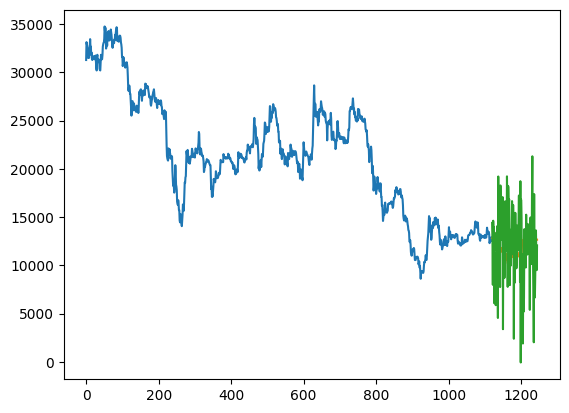

In [14]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
line1, = plt.plot(train_data_index, train['close'], label="Train")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line2, = plt.plot(test_data_index, test['close'], label="Test")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line3, = plt.plot(test_data_index, prediction, label="Predictions")
# predict_90_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
# line4, = plt.plot(predict_90_days_index, predict_90_days[:90], label="Next 90 days")
# predict_60_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
# line5, = plt.plot(predict_60_days_index, predict_90_days[:60], label="Next 60 days")
# predict_30_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
# line6, = plt.plot(predict_30_days_index, predict_90_days[:30], label="Next 30 days")
# plt.legend(handles=[line1, line2, line3, line6, line5, line4])
plt.savefig("SEMOS_HVN_91.png")
plt.show()

In [15]:
# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(test_close,prediction))

# Calculate MAPE
test_mape = mean_absolute_percentage_error(test_close, prediction) * 100

# Calculate MLSE
test_mlse = mean_squared_log_error(test_close, prediction)

print("RMSE:", test_rmse)
print("MAPE:", test_mape, "%")
print("MSLE:", test_mlse)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [ ]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)